In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [10]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print(x_train.shape, y_train.shape)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step
(50000, 32, 32, 3) (50000, 1)


In [11]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4

transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [12]:
data_augmentation = keras.Sequential([
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.2, 0.2),
], name="data_augmentation")

data_augmentation.layers[0].adapt(x_train)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="gelu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# ====== Patch Extraction Layer ======

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [tf.shape(images)[0], -1, patch_dims])
        return patches

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(num_patches, projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [15]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)
    patches = Patches(patch_size)(x)
    x = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention, x])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, transformer_units, 0.1)
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = mlp(x, mlp_head_units, 0.5)
    outputs = layers.Dense(num_classes)(x)

    return keras.Model(inputs, outputs)


In [16]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint = "/tmp/vit_checkpoint.weights.h5"
    ckpt_callback = keras.callbacks.ModelCheckpoint(
        checkpoint,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x_train, y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[ckpt_callback]
    )

    model.load_weights(checkpoint)
    _, acc, top5 = model.evaluate(x_test, y_test)
    print("Test Accuracy:", acc * 100)
    print("Top-5 Accuracy:", top5 * 100)

    return history

vit = create_vit_classifier()
history = run_experiment(vit)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 431ms/step - accuracy: 0.0255 - loss: 4.9132 - top-5-accuracy: 0.1032 - val_accuracy: 0.0884 - val_loss: 4.0227 - val_top-5-accuracy: 0.2818
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 72s 406ms/step - accuracy: 0.0786 - loss: 4.0649 - top-5-accuracy: 0.2512 - val_accuracy: 0.1448 - val_loss: 3.6535 - val_top-5-accuracy: 0.3830
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 70s 397ms/step - accuracy: 0.1190 - loss: 3.7717 - top-5-accuracy: 0.3417 - val_accuracy: 0.1846 - val_loss: 3.3920 - val_top-5-accuracy: 0.4622
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 71s 406ms/step - accuracy: 0.1499 - loss: 3.5669 - top-5-accuracy: 0.4062 - val_accuracy: 0.2128 - val_loss: 3.2285 - val_top-5-accuracy: 0.5080
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 391ms/step - accuracy: 0.1840 - loss: 3.3858 - top-5-accuracy: 0.4564 - val_accuracy: 0.2442 - val_loss: 3.0749 - val_top-5-accuracy: 0.5428
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 394ms/step - accuracy: 0.2008 

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


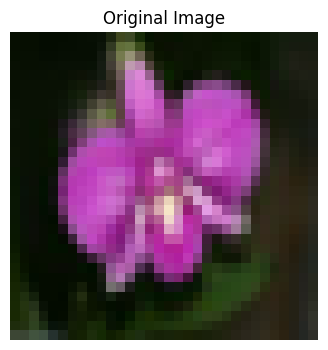

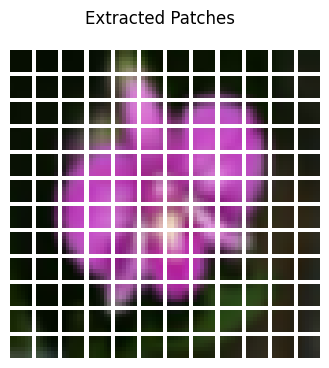

In [17]:

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# Resize image
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

# Extract patches
patches = Patches(patch_size)(resized_image)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Visualize all patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.suptitle("Extracted Patches")
plt.show()


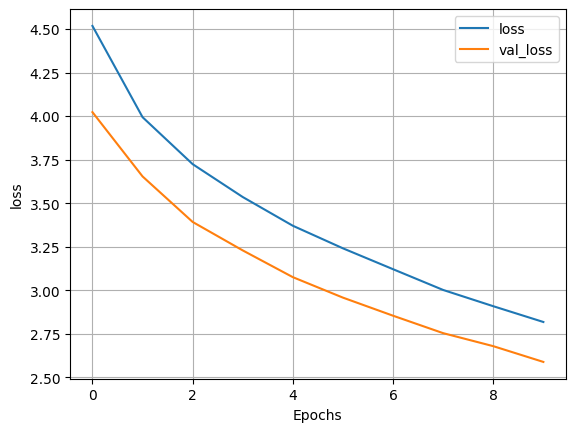

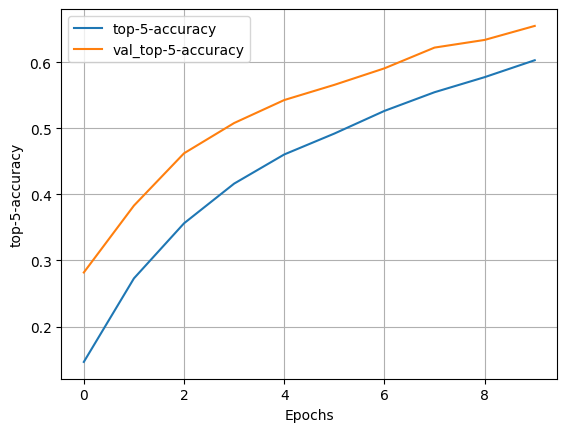

In [18]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history("loss")
plot_history("top-5-accuracy")